In [1]:
% run utils.ipynb

In [2]:
import json

In [3]:
def save(data, name):
    with open('../data/out.{}.json'.format(name), 'w') as f:
        json.dump(data, f, ensure_ascii=False)

In [4]:
lang_locations = pd.read_csv('../data/languages_coordinates.csv')
lang_locations.drop(['glottocode', 'macroarea'], 1, inplace=True)
lang_locations.head()

,name,isocode,level,latitude,longitude
0,Aalawa,NaN,dialect,NaN,NaN
1,Aantantara,NaN,dialect,NaN,NaN
2,Aari,aiw,language,5.95034,36.5721
3,Aariya,aay,language,NaN,NaN
4,Aasax,aas,language,-4.00679,36.8648


In [5]:
lang_locations.shape

(18975, 5)

In [6]:
relations = pd.read_csv('../data/etymwn.tsv', sep='\t', header=None)
relations.columns = ['src', 'rel', 'to']
relations = relations.assign(
    src_lang=relations.src.apply(lambda x: x.split(':')[0].strip()),
    src_word=relations.src.apply(lambda x: x.split(':')[1].strip().lower()),
    to_lang=relations.to.apply(lambda x: x.split(':')[0].strip()),
    to_word=relations.to.apply(lambda x: x.split(':')[1].strip().lower()),
)
relations = relations[
    ~relations.src_word.str.contains('-') & 
    ~relations.src_word.str.contains('\[') & 
    ~relations.to_word.str.contains('-') &
    ~relations.to_word.str.contains('\[') &
    ~relations.rel.isin(['rel:is_derived_from', 'rel:etymologically_related', 'derived'])
]
relations = relations[relations.to_word != relations.src_word]
relations.drop_duplicates(inplace=True)
relations.head()

,src,rel,to,src_lang,src_word,to_lang,to_word
0,aaq: Pawanobskewi,rel:etymological_origin_of,eng: Penobscot,aaq,pawanobskewi,eng,penobscot
1,aaq: senabe,rel:etymological_origin_of,eng: sannup,aaq,senabe,eng,sannup
2,abe: waniigan,rel:etymological_origin_of,eng: wangan,abe,waniigan,eng,wangan
3,abe: waniigan,rel:etymological_origin_of,eng: wannigan,abe,waniigan,eng,wannigan
5,adt: yuru,rel:etymological_origin_of,eng: euro,adt,yuru,eng,euro


In [7]:
relations.shape

(2819080, 7)

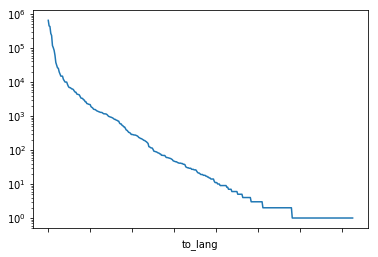

In [8]:
words_per_lang = relations.groupby(relations.to_lang).count().to_word
words_per_lang.sort_values(ascending=False).plot(logy=True);

In [9]:
min_word = 20
langs = pd.Series(words_per_lang[words_per_lang > min_word].index)
langs.sort_values()
langs.shape

(181,)

In [10]:
lang_locations[lang_locations.isocode.isin(langs)].shape

(153, 5)

In [11]:
macrolangs = pd.read_csv('../data/macrolanguages.tsv', sep='\t')
macrolangs.drop(['I_Status'], 1, inplace=True)
macrolangs = macrolangs[~macrolangs.I_Id.isin(langs) & macrolangs.I_Id.isin(lang_locations.isocode)]
macrolangs = dict(macrolangs.groupby(macrolangs.M_Id).first().reset_index().values)
len(macrolangs)

61

In [12]:
unknown_lang = ~langs.isin(lang_locations.isocode)
langs[unknown_lang] = langs[unknown_lang].apply(macrolangs.get)
langs = langs[langs.values != None]
langs.shape

(171,)

In [13]:
lang_locations_patch = np.array([
    [34.5, 41],
    [37.1, -3.5],
    [51, 0],
    [40.3, 45],
    [28, 84.5],
    [52, 5],
    [52, -1],
    [48, 2],
    [48.649, 11.4676],
    [48.649, 13.4676],
    [59.92, 10.71],
    [52, 5],
    [52, 0],
    [47, 2],
    [53.3, 6.3],
    [47.649, 12.4676],
    [53.2, -7.5],
    [55.7, 12],
    [32, 50],
    [44.3, 4],
    [56, 37],
    [51.152, 12.692],
    [40.4414, -1.11788],
    [39.8667, 32.8667],
    [52, -4],
    [32, 50],
    [52, 14]
])
lang_locations_patch.shape

(27, 2)

In [14]:
lang_locations.loc[lang_locations.isocode.isin(langs) & lang_locations.latitude.isnull(), ['latitude', 'longitude']] = lang_locations_patch

In [15]:
lang_locations[lang_locations.isocode.isin(langs) & lang_locations.latitude.isnull()]

,name,isocode,level,latitude,longitude


In [16]:
lang_locations = lang_locations[lang_locations.isocode.isin(langs)]
lang_locations.shape

(171, 5)

In [17]:
relations = relations[relations.src_lang.isin(langs) & relations.to_lang.isin(langs)]
relations.shape

(2766291, 7)

In [18]:
parents_rel = relations[relations.rel != 'rel:etymology']
parents_rel.shape

(2486467, 7)

In [19]:
words = set()
words.update(relations.src_word)
words.update(relations.to_word)
len(words)

2523340

In [20]:
word_per_lang = pd.DataFrame(dict(
    word=np.r_[relations.src_word, relations.to_word],
    lang=np.r_[relations.src_lang, relations.to_lang],
))
word_per_lang.shape

(5532582, 2)

In [21]:
word_langs = dict(word_per_lang.groupby(word_per_lang.word).lang.apply(lambda x: list(np.unique(x))).reset_index().values)
len(word_langs)

2523340

In [22]:
save(word_langs, 'word_langs')

In [23]:
word_per_lang.head()

,lang,word
0,afr,afrikaner
1,afr,april
2,afr,augustus
3,afr,desember
4,afr,egipte


In [24]:
lang_cases = word_per_lang.groupby(word_per_lang.lang).word.apply(list)
lang_cases.head()

lang
afr    [afrikaner, april, augustus, desember, egipte,...
aii    [אבא, אבא, אבא, אדרבא, אמתלא, ארדיכלא, בבא מצי...
akk    [akkadu, zaqāru, ziqqurratu, ziqqurratu, 𒀀𒂵𒄠, ...
ang    [agustus, babilon, babilon, bruning, cantwarab...
arg    [chesús, a, abella, allo, as, ascuitar, au, au...
Name: word, dtype: object

In [30]:
lang_count = word_per_lang.groupby(word_per_lang.lang).word.count()
lang_count.head()

lang
afr      946
aii       50
akk      132
ang    10002
arg      152
Name: word, dtype: int64

In [25]:
lang_len_means = lang_cases.apply(lambda w: float(np.mean([len(x) for x in w])))
lang_len_means.head()

lang
afr    6.397463
aii    4.680000
akk    2.795455
ang    6.091182
arg    6.046053
Name: word, dtype: float64

In [26]:
lang_len_percentiles = lang_cases.apply(lambda w: np.percentile([len(x) for x in w], [25, 50, 75]))
lang_len_percentiles.head()

lang
afr    [4.0, 6.0, 8.0]
aii    [4.0, 5.0, 5.0]
akk    [2.0, 2.0, 3.0]
ang    [4.0, 6.0, 7.0]
arg    [4.0, 6.0, 7.0]
Name: word, dtype: object

In [27]:
lang_len_std = lang_cases.apply(lambda w: float(np.std([len(x) for x in w])))
lang_len_std.head()

lang
afr    2.719935
aii    1.406272
akk    1.972303
ang    2.272895
arg    2.586246
Name: word, dtype: float64

In [28]:
lang_cases_letters = lang_cases.apply(lambda w: [x for xx in w for x in xx])
lang_cases_letters.head()

lang
afr    [a, f, r, i, k, a, n, e, r, a, p, r, i, l, a, ...
aii    [א, ב, א, א, ב, א, א, ב, א, א, ד, ר, ב, א, א, ...
akk    [a, k, k, a, d, u, z, a, q, ā, r, u, z, i, q, ...
ang    [a, g, u, s, t, u, s, b, a, b, i, l, o, n, b, ...
arg    [c, h, e, s, ú, s, a, a, b, e, l, l, a, a, l, ...
Name: word, dtype: object

In [29]:
lang_letters = lang_cases_letters.apply(lambda w: [(l, int(c)) for l, c in zip(*np.unique(w, return_counts=True))])
lang_letters.head()

lang
afr    [(a, 610), (b, 214), (c, 3), (d, 259), (e, 924...
aii    [( , 2), (ּ, 2), (א, 58), (ב, 16), (ד, 8), (ה,...
akk    [(", 1), (., 2), (a, 12), (d, 3), (e, 2), (g, ...
ang    [( , 43), (", 6), (,, 7), (., 14), (a, 5434), ...
arg    [( , 3), (a, 124), (b, 29), (c, 63), (d, 27), ...
Name: word, dtype: object

In [31]:
lang_stats = pd.DataFrame(dict(
    count=lang_count,
    mean=lang_len_means,
    std=lang_len_std,
    percentile25=lang_len_percentiles.apply(lambda x: float(x[0])),
    percentile50=lang_len_percentiles.apply(lambda x: float(x[1])),
    percentile75=lang_len_percentiles.apply(lambda x: float(x[2])),
    histogram=lang_letters
))
lang_stats.head()

,count,histogram,mean,percentile25,percentile50,percentile75,std
lang,,,,,,,
afr,946,"[(a, 610), (b, 214), (c, 3), (d, 259), (e, 924...",6.397463,4.0,6.0,8.0,2.719935
aii,50,"[( , 2), (ּ, 2), (א, 58), (ב, 16), (ד, 8), (ה,...",4.680000,4.0,5.0,5.0,1.406272
akk,132,"[("", 1), (., 2), (a, 12), (d, 3), (e, 2), (g, ...",2.795455,2.0,2.0,3.0,1.972303
ang,10002,"[( , 43), ("", 6), (,, 7), (., 14), (a, 5434), ...",6.091182,4.0,6.0,7.0,2.272895
arg,152,"[( , 3), (a, 124), (b, 29), (c, 63), (d, 27), ...",6.046053,4.0,6.0,7.0,2.586246


In [32]:
src_to_count = relations.groupby(relations.to_lang).to_word.count()
src_to_count.head()

to_lang
afr     473
aii      25
akk      66
ang    5001
arg      76
Name: to_word, dtype: int64

In [33]:
src_to = parents_rel.groupby([parents_rel.src_lang, parents_rel.to_lang]).count().rel
src_to.shape

(1593,)

In [34]:
src_to.head()

src_lang  to_lang
afr       afr        283
          deu          2
          eng         15
          nld          2
          por          1
Name: rel, dtype: int64

In [35]:
network_to = {}

for (src, to), count in src_to.items():
    if src not in network_to:
        network_to[src] = []
        
    ratio = count# / src_to_count.loc[to]
    #assert ratio <= 1
    network_to[src].append([to, ratio])

In [36]:
to_src_count = relations.groupby(relations.src_lang).src_word.count()
to_src_count.head()

src_lang
afr     473
aii      25
akk      66
ang    5001
arg      76
Name: src_word, dtype: int64

In [37]:
to_src = parents_rel.groupby([parents_rel.to_lang, parents_rel.src_lang]).count().rel
to_src.shape

(1593,)

In [38]:
to_src.head()

to_lang  src_lang
afr      afr         283
         deu           1
         fra           1
         nld         127
         por           1
Name: rel, dtype: int64

In [39]:
network_from = {}

for (to, src), count in to_src.items():
    if to not in network_from:
        network_from[to] = []
        
    ratio = count# / to_src_count.loc[src]
    #assert ratio <= 1
    network_from[to].append([src, ratio])

In [40]:
save({
    'to': network_to,
    'from': network_from,
    'locations': lang_locations.set_index('isocode').to_dict('index'),
    'stats': lang_stats.to_dict('index')
}, 'lang_network')    

In [ ]:
mappings = pd.read_csv('../data/uwn.tsv', sep='\t', header=None)
mappings.columns = ['src', 'rel', 'to', 'weight']
mappings = mappings[mappings.rel != 'rel:means']
mappings = mappings.assign(
    lang=mappings.to.apply(lambda x: x.split('/')[1].strip()),
    word=mappings.to.apply(lambda x: x.split('/')[2].strip().lower()),
)
mappings = mappings[mappings.word.isin(words) & mappings.lang.isin(langs)]
mappings.drop(['weight', 'rel'], axis=1, inplace=True)
mappings.set_index('src', inplace=True)
mappings.head()

In [ ]:
mappings.shape

In [ ]:
clusters = mappings.groupby(mappings.index).apply(lambda x: list(x.lang.str.cat(':' + x.word)))
clusters.head()

In [ ]:
meanings = {}

for _, cluster in tqdm(clusters.items()):
        
    for lang_word in cluster:
        
        if lang_word not in meanings:
            meanings[lang_word] = set()
            
        meanings[lang_word].update(cluster)
        meanings[lang_word].remove(lang_word)
        
for key, values in meanings.items():
    meanings[key] = list(values)

In [ ]:
len(meanings)

In [ ]:
save(meanings, 'word_meanings')

In [ ]:
parents = pd.DataFrame(dict(
     src=parents_rel.src_lang + ':' + parents_rel.src_word + ',',
    to=parents_rel.to_lang + ':' + parents_rel.to_word,
)).groupby('to').src.sum()
parents.head()

In [ ]:
parents_map = dict(parents.apply(lambda x: x.split(',')[:-1]).reset_index().values)
len(parents_map)

In [ ]:
save(parents_map, 'word_parents')

In [ ]:
children = pd.DataFrame(dict(
     src=parents_rel.src_lang + ':' + parents_rel.src_word,
    to=parents_rel.to_lang + ':' + parents_rel.to_word + ',',
)).groupby('src').to.sum()
children.head()

In [ ]:
children_map = dict(children.apply(lambda x: x.split(',')[:-1]).reset_index().values)
len(children_map)

In [ ]:
save(children_map, 'word_children')

In [ ]:
def recurse(lang_word, mapping, seen=None):
    if seen is None:
        seen = set()

    if lang_word in seen:
        return []
    
    seen.add(lang_word)
    ps = mapping.get(lang_word, [])
    return [(p, recurse(p, mapping, seen.copy())) for p in ps]

In [ ]:
recurse('eng:dog', parents_map)

In [ ]:
recurse('eng:dog', children_map)

In [ ]:
def recurse_unfold(lang_word, mapping):
    
    edges = []
    depth = 0
    
    def edgify(lang_word, history=[], seen=None):
        if seen is None:
            seen = set()
        
        ps = mapping.get(lang_word, [])

        if lang_word in seen:
            edges.append(history)
            return
        
        if not len(ps):
            edges.append(history + [lang_word])
            return

        seen.add(lang_word)
        [edgify(p, history + [lang_word], seen.copy()) for p in ps]

    edgify(lang_word)
    return edges

In [ ]:
recurse_unfold('eng:dog', parents_map)

In [ ]:
recurse_unfold('eng:dog', children_map)

In [ ]:
lang_words = (parents_rel.src_lang + ':' + parents_rel.src_word).values
lang_words.shape

In [ ]:
lang_influences = {}

for lang_word in tqdm(lang_words):
    edges = recurse_unfold(lang_word, parents_map) + recurse_unfold(lang_word, children_map)
    
    for edge in edges:
        lang = edge[0].split(':')[0]

        if lang not in lang_influences:
            lang_influences[lang] = []

        lang_influences[lang].append(edge)

In [ ]:
lang_influences_ord = { k: sorted(v, key=len, reverse=True) for k, v in tqdm(lang_influences.items()) }

In [ ]:
n_samples = 50

In [ ]:
lang_samples = {}

for lang in tqdm(langs):
    if lang in lang_influences:
        top_starters = [lang_word[0].split(':')[1] for lang_word in lang_influences_ord[lang]]

        lang_samples[lang] = [top_starters[i] for i in sorted(np.unique(top_starters, return_index=True)[1])][:n_samples]

In [ ]:
save(lang_samples, 'lang_samples')

In [ ]:
relation_groups = relations.groupby(relations.src_lang).apply(lambda x: x.groupby(x.to_lang).src_word.apply(list))
relation_groups.shape

In [ ]:
relation_samples = {}

for _, (src, to, words) in tqdm(relation_groups.reset_index().iterrows()):
    relation = '{}{}'.format(src, to)
    relation_samples[relation] = np.random.choice(words, min(n_samples, len(words))).tolist()

In [ ]:
save(relation_samples, 'relation_samples')